Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


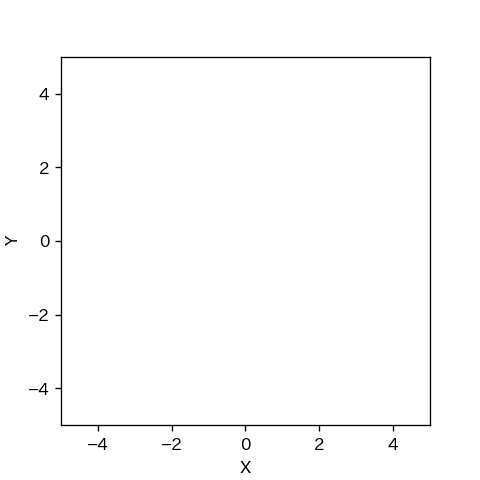

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import*

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): 
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
                
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.sensor_resetting(observation) 
        else:
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-2,-2))
    m.append_landmark(Landmark(2,-2))
    m.append_landmark(Landmark(0,2*math.sqrt(3)-2))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-4.0,-2.0),np.random.uniform(-4.0,4.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


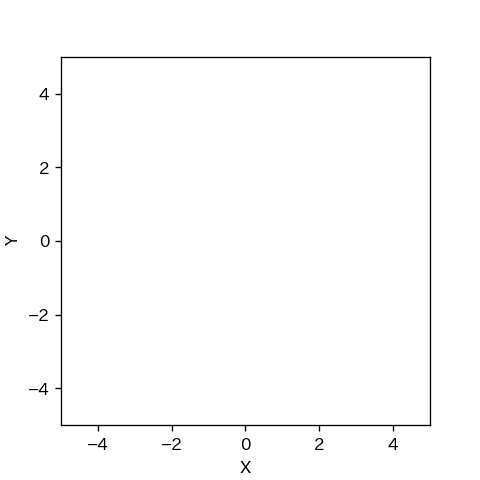

(array([-2.45559584,  0.77499914,  1.12985063]),
 array([-0.78737481,  2.69232101, -0.54862391]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

[4.600056020436842, 3.2684574148856256]
0 真値: [-1.80362946  4.72880965  3.17512264] 推定値: [-0.79004566  4.4031766   3.66384587] 誤差: 1.0646074350559405
[5.132848882416931]
1 真値: [-5.72431938 -0.03556785  4.81900942] 推定値: [-6.10367254  0.42011593  4.81432368] 誤差: 0.5929220272389358
1
[5.793905178941624, 8.980928828860915]
[4.779307088025664, 6.705638581002038]
[5.562806542954627, 7.09213888108885]
[4.599828217220408, 10.006651495267974]
[5.493648545674848, 7.552479221600234]
[2.8506947656250703, 7.562566834193726]
[2.621475658726114, 6.47104760866968]
2 真値: [-1.01020746 -3.82679882  7.44209172] 推定値: [-0.28171542 -4.47120869  1.36602352] 誤差: 0.9726071870048165
2
[1.9400168162037206]
[1.8889626573019227, 5.972403026037664]
[1.9269193354003429, 6.173091207913157]
3 真値: [-2.30924884 -2.00399452  7.48671609] 推定値: [-2.3960304  -2.00387801  1.19490891] 誤差: 0.0867816385483071
3
[1.7047034090708106]
4 真値: [-1.70389522 -0.99541522  7.99328629] 推定値: [-1.54530685 -0.99562621  1.66206894] 誤差: 0.158588

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[4.99938167607879]
[4.285938909025947, 2.538763696989931]
20 真値: [-2.45006087  3.49590472  4.0163389 ] 推定値: [-1.70262501  3.40607244  3.89122561] 誤差: 0.7528148536549226
16
[2.9339082928523728]
21 真値: [-2.16377681 -3.08384714  1.25510682] 推定値: [-2.26055256 -2.8900972   1.17313592] 誤差: 0.21657465686647112
17
[4.94915542017795, 5.792073974497844]
22 真値: [-1.92235808 -1.04562289  2.7063754 ] 推定値: [-1.83421895 -0.74986804  2.6913423 ] 誤差: 0.30860887670794807
18
[6.308622258308782]
[1.801417795693371, 5.449996916767029]
23 真値: [-2.61853869 -2.32805457  8.49761942] 推定値: [-2.50015398 -2.43396314  2.27534674] 誤差: 0.15884446466368682
19
[2.339129511187323]
[1.1863980907611464, 7.428633297277186]
[1.1553765720677034, 5.093891781910229]
24 真値: [-1.39353494 -0.58890179  1.78882624] 推定値: [-1.68839968 -0.7137058   1.74703879] 誤差: 0.3201894093909414
20
[7.05640644206561]
25 真値: [-3.32701672  2.7014451   7.80439801] 推定値: [-3.4009324   2.71730907  1.5862579 ] 誤差: 0.07559889589759443
21
[2.36116308917201